# Modelling of a Geared DC Motor

**Balck-box modelling of a DC Motor using FNN, CNN and LSTM**

- Input: PWM signal
- Output : Angular speed

<h5> DC Motor specification </h5>

-   12 DVC
-   Gear ration 10:1


<h4> Experimental Settings  </h4>

-   Sampling time- 0.002s
-   Duration- 500s

In [51]:
#  Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import tensorflow
from numpy.random import seed
tf.random.set_seed(10)
# setting the seed
seed(10)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, Flatten, Dropout,InputLayer

from tensorflow.keras.layers import RNN, Layer,LSTM, SimpleRNN
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow import float32, concat, convert_to_tensor, linalg



In [52]:
# data
exp_data = pd.read_csv('C:/Users/Samual/OneDrive - aucegypt.edu/Documents/PYTHON/Neural Networks and ML- Geared DC Motor Case Study/DC_Motor_experimental_data_training.csv')
exp_data

,0,40.5,0.1
0,0.020000,40.5,0.000000
1,0.040000,40.5,0.980267
2,0.060000,40.5,0.941830
3,0.080000,40.5,1.885167
4,0.100000,40.5,3.771782
...,...,...,...
24995,499.919983,255.0,300.932159
24996,499.940002,255.0,300.895599
24997,499.959992,255.0,300.860474
24998,499.979981,255.0,300.826721


In [37]:
exp_data.columns = ['time', 'voltage', 'speed']
exp_data

,time,voltage,speed
0,0.020000,40.5,0.000000
1,0.040000,40.5,0.980267
2,0.060000,40.5,0.941830
3,0.080000,40.5,1.885167
4,0.100000,40.5,3.771782
...,...,...,...
24995,499.919983,255.0,300.932159
24996,499.940002,255.0,300.895599
24997,499.959992,255.0,300.860474
24998,499.979981,255.0,300.826721


C:\Users\Samual\Anaconda3\envs\deep_env2\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Samual\Anaconda3\envs\deep_env2\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Samual\Anaconda3\envs\deep_env2\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


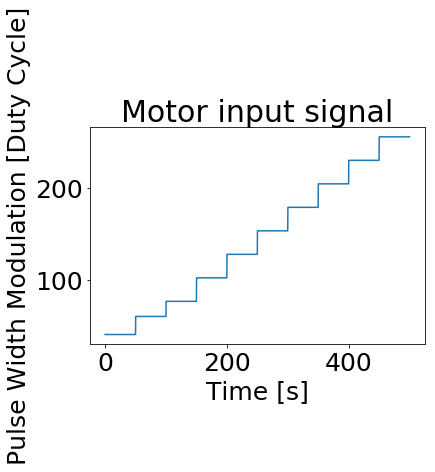

In [38]:
# Motor Input Signal
plt.plot(exp_data['time'][:-1],exp_data['voltage'][:-1])
plt.ylabel('Pulse Width Modulation [Duty Cycle]')
plt.xlabel('Time [s]')
plt.title('Motor input signal')
plt.show()
print('\n')

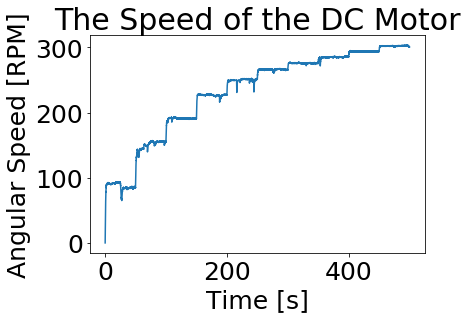

In [39]:
# Motor Output Plot
plt.plot(exp_data['time'][:-1],exp_data['speed'][:-1])
plt.ylabel('Angular Speed [RPM]')
plt.xlabel('Time [s]')
plt.title('The Speed of the DC Motor')
plt.show()
print('\n')

In [40]:
# Data for training
exp_data = pd.read_csv('C:/Users/Samual/OneDrive - aucegypt.edu/Documents/PYTHON/Neural Networks and ML- Geared DC Motor Case Study/DC_Motor_experimental_data_training.csv')
exp_data.columns = ['time', 'voltage', 'speed']
# range
l=25000
exp_data_tr=exp_data.iloc[0:l,:]

time=exp_data_tr['time']
t=np.array(time)

input_1=exp_data_tr['voltage']
xtr=np.array(input_1)
X_train=xtr.reshape(l,1)

output_1=exp_data_tr['speed']
ytr=np.array(output_1)
Y_train=ytr.reshape(l,1)

#Data for testing
new_data = pd.read_csv('C:/Users/Samual/OneDrive - aucegypt.edu/Documents/PYTHON/Neural Networks and ML- Geared DC Motor Case Study/DC_Motor_experimental_data_testing.csv')
new_data.columns = ['time', 'voltage', 'speed']

time_test=new_data['time']
t_test=np.array(time_test)

input_2=new_data['voltage']
xts=np.array(input_2)
X_test=xts.reshape(l,1)

output_2=new_data['speed']
yts=np.array(output_2)
Y_test=yts.reshape(l,1)

<h2> Data Transformation<h2>

In [41]:

def data_transform(x_data, y_data, num_steps):
    """ Changes data to the format for CNN and LSTM training for sliding window approach """
    # Prepare the list for the transformed data
    X, Y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x data
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y data
        seq_Y = y_data[end_ix]
        # Append the list with the sequence
        X.append(seq_X)
        Y.append(seq_Y)
    # Make final arrays
    x_trans_array = np.array(X)
    y_trans_array = np.array(Y)
    return x_trans_array, y_trans_array

In [42]:
# Training Data
num_steps = 1
x_new, y_new = data_transform(X_train, Y_train, num_steps=num_steps)
#print(x_new)
print ("The transformed shape of x and y are:", x_new.shape,"and", y_new.shape)

The transformed shape of x and y are: (24999, 1, 1) and (24999, 1)


In [43]:
# Test data
num_steps = 1
x_nnew, y_nnew = data_transform(X_test, Y_test, num_steps=num_steps)
print ("The transformed shape of x and y are:", x_nnew.shape,"and",y_nnew.shape)

The transformed shape of x and y are: (24999, 1, 1) and (24999, 1)


<h2>Feedforward Neural Network (FNN) Model<h2>

In [53]:
model0=Sequential()
model0.add(Dense(100, input_dim=1,activation='tanh'))
model0.add(Dense(50, input_dim=1,activation='tanh'))
model0.add(Dense(10, activation='relu'))
model0.add(Dense(1,activation="linear"))
model0.summary()

#compile model
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model0.compile(optimizer=opt, loss='mse')

from time import time
# Start timer
t0 = time()
#hist0=model0.fit(X_train,Y_train,epochs=10,validation_data = (X_test, Y_test),verbose=2)
hist0=model0.fit(x_new, y_new, epochs=20,verbose=2,validation_data=(x_nnew,y_nnew))
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_23 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_24 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 11        
Total params: 5,771
Trainable params: 5,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
782/782 - 8s - loss: 51328.5664 - val_loss: 46197.4180
Epoch 2/20
782/782 - 7s - loss: 41497.7109 - val_loss: 36268.0742
Epoch 3/20
782/782 - 7s - loss: 31339.7773 - val_loss: 26252.0918
Epoch 4/20
782/782 - 7s - loss: 21786.1211 - val_los

dict_keys(['loss', 'val_loss'])


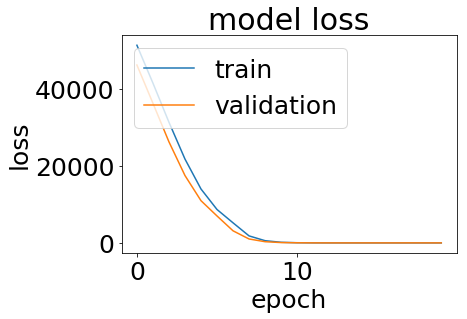

In [54]:
#Plotting of Loss
print(hist0.history.keys())
plt.plot(hist0.history['loss'])
plt.plot(hist0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [55]:
# Prediiction with test data
prediction0=model0.predict(x_nnew) ######### prediction with test data
print(prediction0.shape)
prediction0

(24999, 1)


array([[ 88.009224],
       [ 88.009224],
       [ 88.009224],
       ...,
       [301.63403 ],
       [301.63403 ],
       [301.63403 ]], dtype=float32)

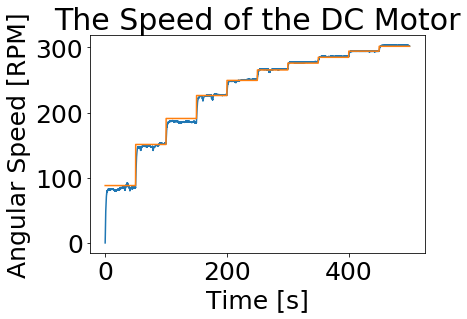

In [56]:
# Plotting the Model Prediction
plt.plot(t_test[num_steps:],y_nnew)
plt.plot(t_test[num_steps:],prediction0)
plt.ylabel('Angular Speed [RPM]')
plt.xlabel('Time [s]')
plt.title('The Speed of the DC Motor')
plt.show()
print('\n')

<h5>Save FNN Model<h5>

In [57]:
# save model and architecture to single file
model0.save("DC_motor_model_FNN.h5")
print("Model has been saved to disk")
from tensorflow.keras.models import load_model
# load model
model_FNN = load_model('DC_motor_model_FNN.h5')

Model has been saved to disk


<h2>Convolutional Neural Network (CNN) Model<h2>

In [58]:
model1=Sequential()
model1.add(Conv1D(filters=128,kernel_size=1, activation='tanh', input_shape=(num_steps,1)))
model1.add(Conv1D(filters=64,kernel_size=1, activation='tanh'))
model1.add(Flatten())
model1.add(Dense(5, activation='relu'))
model1.add(Dense(1, activation='linear'))

# Model Compile and Fit
opt = tensorflow.keras.optimizers.Adam(lr=0.0001)
model1.compile(optimizer=opt, loss='mse')
model1.summary()

from time import time
# Start timer
t0 = time()
hist1=model1.fit(x_new, y_new, epochs=20,verbose=2,validation_data=(x_nnew,y_nnew))
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 1, 128)            256       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 64)             8256      
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 325       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 6         
Total params: 8,843
Trainable params: 8,843
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
782/782 - 16s - loss: 54402.9961 - val_loss: 51747.3750
Epoch 2/20
782/782 - 8s - loss: 49389.5938 - val_lo

dict_keys(['loss', 'val_loss'])


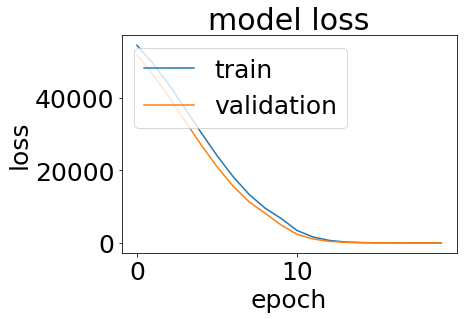

In [59]:
#Plotting of Loss
print(hist1.history.keys())
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [60]:
# Prediiction with test data
prediction1=model1.predict(x_nnew) ######### prediction with test data
print(prediction1.shape)
prediction1

(24999, 1)


array([[ 88.30484],
       [ 88.30484],
       [ 88.30484],
       ...,
       [300.19025],
       [300.19025],
       [300.19025]], dtype=float32)

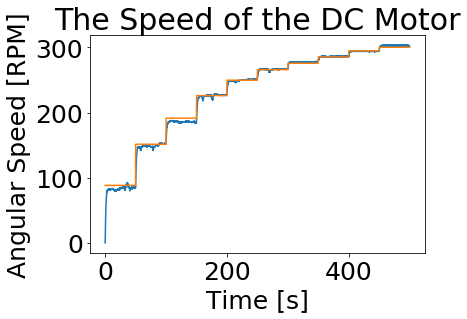

In [61]:
# Plottinf the Model Prediction
plt.plot(t_test[num_steps:],y_nnew)
plt.plot(t_test[num_steps:],prediction1)
plt.ylabel('Angular Speed [RPM]')
plt.xlabel('Time [s]')
plt.title('The Speed of the DC Motor')
plt.show()
print('\n')

<h5>Save CNN Model<h5>

In [62]:
# save model and architecture to single file
model1.save("DC_motor_model_CNN.h5")
print("Model has been saved to disk")
from tensorflow.keras.models import load_model
# load model
model_CNN = load_model('DC_motor_model_CNN.h5')

Model has been saved to disk


<h2>Long Short Term Memory (LSTM) Model<h2>

In [63]:
model2 = Sequential()
model2.add(LSTM(100, activation='tanh', input_shape=(num_steps, 1),return_sequences=False))
model2.add(Dense(units=50, activation='relu'))
model2.add(Dense(units=1, activation='linear'))
adam = tensorflow.keras.optimizers.Adam(lr=0.0001)
model2.compile(optimizer=adam, loss='mse')
from time import time
# Start timer
t0 = time()
hist2=model2.fit(x_new, y_new, epochs=20,verbose=2,validation_data=(x_nnew,y_nnew))
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))


Epoch 1/20
782/782 - 16s - loss: 50447.9141 - val_loss: 35495.9375
Epoch 2/20
782/782 - 10s - loss: 22926.6367 - val_loss: 13029.8125
Epoch 3/20
782/782 - 10s - loss: 7517.2056 - val_loss: 3530.8462
Epoch 4/20
782/782 - 10s - loss: 1697.7886 - val_loss: 636.7464
Epoch 5/20
782/782 - 10s - loss: 290.9227 - val_loss: 138.4445
Epoch 6/20
782/782 - 10s - loss: 81.2347 - val_loss: 56.0809
Epoch 7/20
782/782 - 10s - loss: 42.9983 - val_loss: 38.5235
Epoch 8/20
782/782 - 10s - loss: 31.9357 - val_loss: 33.4591
Epoch 9/20
782/782 - 10s - loss: 26.5949 - val_loss: 27.9951
Epoch 10/20
782/782 - 10s - loss: 23.7388 - val_loss: 30.8075
Epoch 11/20
782/782 - 10s - loss: 22.1803 - val_loss: 25.2176
Epoch 12/20
782/782 - 10s - loss: 21.2251 - val_loss: 27.1272
Epoch 13/20
782/782 - 10s - loss: 20.7867 - val_loss: 23.0894
Epoch 14/20
782/782 - 10s - loss: 20.5340 - val_loss: 25.6620
Epoch 15/20
782/782 - 10s - loss: 20.4327 - val_loss: 29.5619
Epoch 16/20
782/782 - 10s - loss: 20.3539 - val_loss: 27.4

dict_keys(['loss', 'val_loss'])


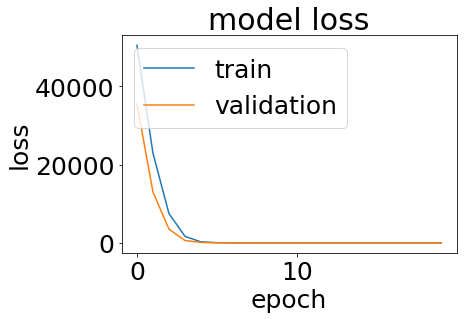

In [64]:
#Plotting of Loss
print(hist2.history.keys())
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [65]:
# Prediiction with test data
prediction2=model2.predict(x_nnew) ######### prediction with test data
print(prediction2.shape)
prediction2

(24999, 1)


array([[ 87.42792],
       [ 87.42792],
       [ 87.42792],
       ...,
       [300.79016],
       [300.79016],
       [300.79016]], dtype=float32)

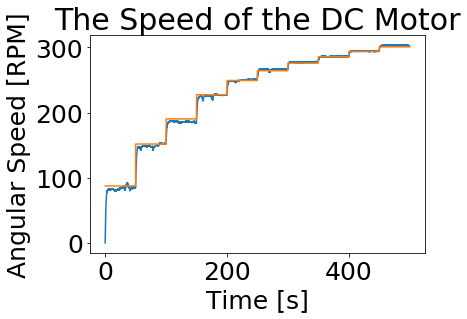

In [66]:
# Plotting the Model Prediction
plt.plot(t_test[num_steps:],y_nnew)
plt.plot(t_test[num_steps:],prediction2)
plt.ylabel('Angular Speed [RPM]')
plt.xlabel('Time [s]')
plt.title('The Speed of the DC Motor')
plt.show()
print('\n')

<h5>Save LSTM Model<h5>

In [67]:
# save model and architecture to single file
model2.save("DC_motor_model_LSTM.h5")
print("Model has been saved to disk")
from tensorflow.keras.models import load_model
# load model
model_LSTM = load_model('DC_motor_model_LSTM.h5')

Model has been saved to disk


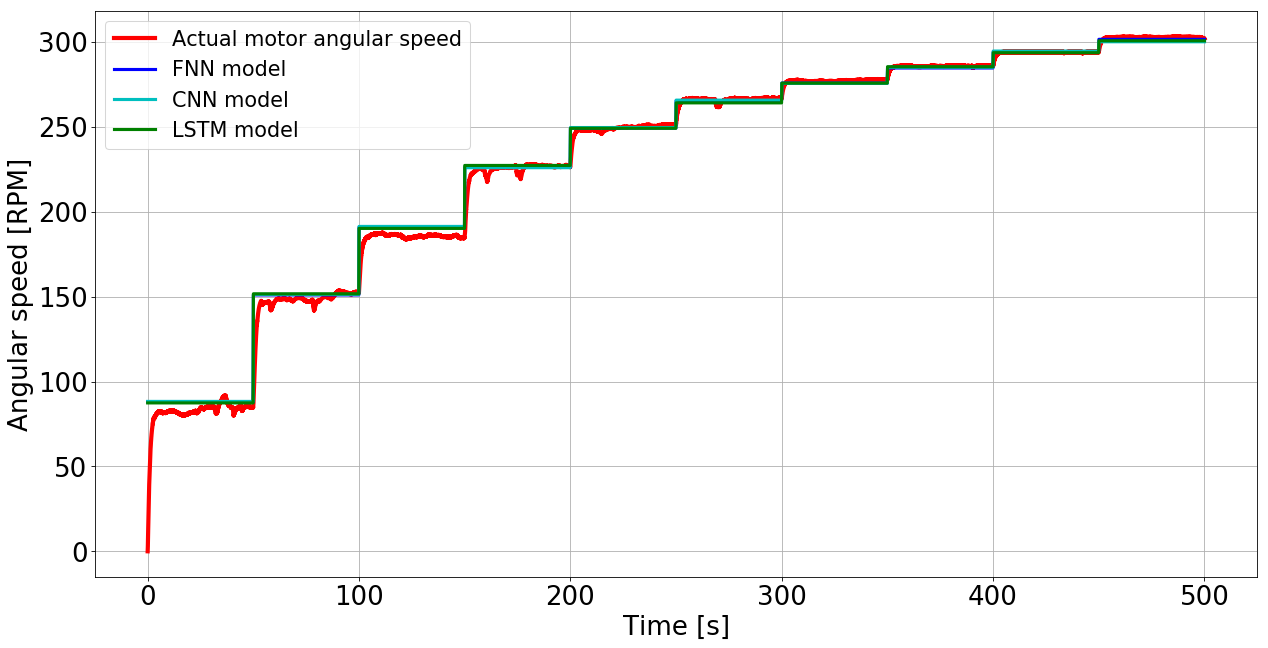

In [68]:
# Plotting the Models
from matplotlib.pyplot import figure
fig=plt.figure(figsize=(20,10),dpi=75)
plt.rcParams.update ({"font.size":25})
plt.plot(t_test[num_steps:],y_nnew, color='r',linewidth=4,label="Actual motor angular speed")
plt.plot(t_test[num_steps:],prediction0, color='b',linewidth=3,label="FNN model")
plt.plot(t_test[num_steps:],prediction1, color='c',linewidth=3,label="CNN model")
plt.plot(t_test[num_steps:],prediction2, color='g',linewidth=3,label="LSTM model")
plt.ylabel('Angular speed [RPM]',fontsize=25)
plt.xlabel('Time [s]',fontsize=25)
#plt.title('The Angular Speed Prediction of Different Geared DC Motor Black-Box Models',fontsize=25)
plt.legend(loc=2, prop={'size': 20})
plt.grid(True)
plt.show()
fig.savefig("Black-box models.png") 
